In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
import joblib

from sklearn.preprocessing import MinMaxScaler, StandardScaler, quantile_transform
from sklearn.model_selection import train_test_split
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import VECM
from statsmodels.tsa.vector_ar.vecm import select_order
from statsmodels.tsa.vector_ar.vecm import select_coint_rank

import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, coint
from scipy.stats import norm
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
from google.colab import files
warnings.filterwarnings('ignore')

In [ ]:
!pip install koreanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 18.8 MB/s eta 0:00:00


In [ ]:
import koreanize_matplotlib

# 파일 경로

In [ ]:
# Load the provided Excel file (로그변환된 데이터)
us_file_paths_log = [
    '/content/미국_서비스_Credit_Risk_Extended_Standardized_Adjusted_transformed_log_transformed.xlsx',
    '/content/미국_소매_Credit_Risk_Extended_Standardized_Adjusted_transformed_log_transformed.xlsx',
    '/content/미국_에너지_Credit_Risk_Extended_Standardized_Adjusted_transformed_log_transformed.xlsx',
    '/content/미국_제조_Credit_Risk_Extended_Standardized_Adjusted_transformed_log_transformed.xlsx',
]

india_file_paths_log = [
    '/content/인도_서비스_Credit_Risk_Extended_Standardized_Adjusted_transformed_log_transformed.xlsx',
    '/content/인도_소매_Credit_Risk_Extended_Standardized_Adjusted_transformed_log_transformed.xlsx',
    '/content/인도_에너지_Credit_Risk_Extended_Standardized_Adjusted_transformed_log_transformed.xlsx',
    '/content/인도_제조_Credit_Risk_Extended_Standardized_Adjusted_transformed_log_transformed.xlsx',
]

japan_file_paths_log = [
    '/content/일본_서비스_credit_risk_Standardized_Adjusted_transformed_log_transformed.xlsx',
    '/content/일본_소매_credit_risk_Standardized_Adjusted_transformed_log_transformed.xlsx',
    '/content/일본_에너지_credit_risk_Standardized_Adjusted_transformed_log_transformed.xlsx',
    '/content/일본_제조_credit_risk_Standardized_Adjusted_transformed_log_transformed.xlsx',
]

korea_file_paths_log = [
    '/content/한국_서비스_credit_risk_Standardized_Adjusted_transformed_log_transformed.xlsx',
    '/content/한국_소매_credit_risk_Standardized_Adjusted_transformed_log_transformed.xlsx',
    '/content/한국_에너지_credit_risk_Standardized_Adjusted_transformed_log_transformed.xlsx',
    '/content/한국_제조_credit_risk_Standardized_Adjusted_transformed_log_transformed.xlsx',
]

all_file_paths_log = [us_file_paths_log,india_file_paths_log,japan_file_paths_log,korea_file_paths_log]

In [ ]:
# Load the provided Excel file (로그변환 안 된 데이터)
us_file_paths = [
  '/content/미국_서비스_Credit_Risk_Extended(filtered).xlsx',
  '/content/미국_소매_Credit_Risk_Extended(filtered).xlsx',
  '/content/미국_에너지_Credit_Risk_Extended(filtered).xlsx',
  '/content/미국_제조_Credit_Risk_Extended(filtered).xlsx',
]

india_file_paths = [
  '/content/인도_서비스_Credit_Risk_Extended(filtered).xlsx',
  '/content/인도_소매_Credit_Risk_Extended(filtered).xlsx',
  '/content/인도_에너지_Credit_Risk_Extended(filtered).xlsx',
  '/content/인도_제조_Credit_Risk_Extended(filtered).xlsx',
]

japan_file_paths = [
  '/content/일본_서비스_credit_risk(filtered).xlsx',
  '/content/일본_소매_credit_risk(filtered).xlsx',
  '/content/일본_에너지_credit_risk(filtered).xlsx',
  '/content/일본_제조_credit_risk(filtered).xlsx',
]

korea_file_paths = [
  '/content/한국_서비스_credit_risk(filtered).xlsx',
  '/content/한국_소매_credit_risk(filtered).xlsx',
  '/content/한국_에너지_credit_risk(filtered).xlsx',
  '/content/한국_제조_credit_risk(filtered).xlsx',
]

all_file_paths = [us_file_paths,india_file_paths,japan_file_paths,korea_file_paths,]

In [ ]:
# 로그 변환된 경제지표 원본 데이터 파일 경로
econ_log_file_paths = [
  '/content/미국_경제지표.xlsx',
  '/content/인도 경제지표.xlsx',
  '/content/일본 경제지표.xlsx',
  '/content/한국 경제지표.xlsx',
]

# 최종_공적분검정 및 정상성검정, 구조적 VAR 및 IRF

In [ ]:
df = pd.read_excel(us_file_paths[0])
df.index = df['기간']
df = df[['gdp성장률', 'avg_cr']]
df['gdp성장률'] = df['gdp성장률']*0.01
df = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)
print(df.dtypes)

gdp성장률    float64
avg_cr    float64
dtype: object


In [ ]:
df['diff_avg_cr'] = df[avg_cr].diff().dropna().astype(str)
df['diff_gdp'] = df[gdp].diff().dropna().astype(str)
df['lag_avg_cr'] = df[avg_cr].shift(1).astype(str)
df['lag_gdp'] = df[gdp].shift(1).astype(str)

# ECM 모형 구성
ecm_data = df[['diff_avg_cr', 'diff_gdp', 'diff_avg_cr', 'lag_gdp']].dropna().astype(str)
print(ecm_data.dtypes)
ecm_data['ecm_term'] = ecm_data['diff_avg_cr'].sub(ecm_data['lag_gdp'])
X = ecm_data[['diff_gdp', 'ecm_term']]
y = ecm_data['diff_avg_cr']

diff_avg_cr    object
diff_gdp       object
diff_avg_cr    object
lag_gdp        object
dtype: object


TypeError: '<' not supported between instances of 'Timestamp' and 'str'

In [ ]:
# 우선 공적분 관계가 있는 데이터와 없는 데이터를 나누고, 공적분 관계가 있다면 오차수정모형을 이용한 회귀분석을,
# 없다면 선형회귀분석을 돌려 GDP성장률과 실업률이 AVG_CR과 갖는 관계를 확인.
# 이후에 비정상성을 띄는 데이터들을 로그변환 후 차분하여 구조적 VAR 실시.

#################### 로그 변환된 데이터에 대한 공적분 검정 및 회귀분석
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    return result[1]

count = 0
gdp="gdp성장률"
unemploy="실업률"
avg_cr="avg_cr"
scaler=StandardScaler()

for file_paths in all_file_paths:
  for file_path in file_paths:
      print(f"Processing file: {file_path}")

      # 데이터 불러오기
      data = pd.read_excel(file_path)
      data.index = data['기간']
      data[gdp] = data[gdp]*0.01
      data[unemploy] = data[unemploy]*0.01
      data = data[[gdp, unemploy, avg_cr]]
      data = pd.DataFrame(scaler.fit_transform(data), index=data.index, columns=data.columns)
      print(data)

      # 정상성 테스트
      print("CR 데이터 정상성 테스트")
      p_value_cr = test_stationarity(data[avg_cr])
      print("\nGDP 데이터 정상성 테스트")
      p_value_gdp = test_stationarity(data[gdp])
      print("\n실업률 데이터 정상성 테스트")
      p_value_unemployment = test_stationarity(data[unemploy])

      # 공적분 테스트 (avg_cr과 gdp 간)
      score, pvalue_gdp, _ = coint(data[avg_cr], data[gdp])
      print("\n공적분 테스트 (avg_cr과 gdp 간)")
      print(f'Cointegration test p-value: {pvalue_gdp}')

      # 공적분 테스트 (avg_cr과 실업률 간)
      score, pvalue_unemployment, _ = coint(data[avg_cr], data[unemploy])
      print("\n공적분 테스트 (avg_cr과 실업률 간)")
      print(f'Cointegration test p-value: {pvalue_unemployment}')

      ##################GDP분석
      if pvalue_gdp < 0.05:
          print("\n GDP와 CR 간의 공적분 관계가 존재하므로 오차수정모형 회귀분석을 실시..")

          df = data[[gdp, avg_cr]].dropna()

          # ECM을 위한 데이터 준비
          data['diff_avg_cr'] = data[avg_cr].diff().dropna()
          data['diff_gdp'] = data[gdp].diff().dropna()
          data['lag_avg_cr'] = data[avg_cr].shift(1)
          data['lag_gdp'] = data[gdp].shift(1)
          print(data)

          # ECM 모형 구성
          ecm_data = data[['diff_avg_cr', 'diff_gdp', 'diff_avg_cr', 'lag_gdp']].dropna()
          ecm_data['ecm_term'] = ecm_data['diff_avg_cr'].sub(ecm_data['lag_gdp'])
          X = ecm_data[['diff_gdp', 'ecm_term']]
          y = ecm_data['diff_avg_cr']

          # ECM 모형 적합
          ecm_model = OLS(y, add_constant(X))
          ecm = ecm_model.fit()
          print(ecm.summary())

          # 잔차의 정상성 테스트
          residuals = ecm.resid
          print("\n잔차의 정상성 테스트 (avg_cr ~ gdp)")
          p_value_residuals = test_stationarity(residuals)

          if p_value_residuals < 0.05:
              print("GDP 잔차가 정상성을 띄고 있음. 공적분 관계가 확인.")
          else:
              print("GDP 잔차가 정상성을 띄지 않음. 공적분 관계가 확인되지 않음.")

      else:
          print("공적분 관계가 존재하지 않으므로 로그 차분 데이터를 이용하여 선형회귀분석을 수행. (avg_cr ~ gdp)")

          # 로그 차분 데이터 생성
          data['d_CR'] = np.log(data[avg_cr]).diff().dropna()
          data['d_GDP'] = np.log(data[gdp]).diff().dropna()

          # 로그 차분 데이터로 회귀분석
          X_diff = data['d_GDP'].dropna()
          y_diff = data['d_CR'].dropna()

          model_diff = OLS(y_diff, add_constant(X_diff)).fit()
          print(model_diff.summary())

      ##################실업률분석
      if pvalue_unemployment < 0.05:
          print("\n 실업률과 CR 간의 공적분 관계가 존재하므로 오차수정모형 회귀분석을 실시..")

          df = data[[unemploy, avg_cr]].dropna()

          # ECM을 위한 데이터 준비
          data['diff_avg_cr'] = data[avg_cr].diff().dropna()
          data['diff_unemploy'] = data[unemploy].diff().dropna()
          data['lag_avg_cr'] = data[avg_cr].shift(1)
          data['lag_unemploy'] = data[unemploy].shift(1)

          # ECM 모형 구성
          ecm_data = data[['diff_avg_cr', 'diff_unemploy', 'diff_avg_cr', 'lag_unemploy']].dropna()
          ecm_data['ecm_term'] = ecm_data['diff_avg_cr'] - ecm_data['lag_unemploy']
          X = ecm_data[['diff_unemploy', 'ecm_term']]
          y = ecm_data['diff_avg_cr']

          # ECM 모형 적합
          ecm_model = OLS(y, add_constant(X))
          ecm = ecm_model.fit()
          print(ecm.summary())

          # 잔차의 정상성 테스트
          residuals = ecm.resid
          print("\n잔차의 정상성 테스트 (avg_cr ~ 실업률)")
          p_value_residuals = test_stationarity(residuals)

          if p_value_residuals < 0.05:
              print("실업률 잔차가 정상성을 띄고 있음. 공적분 관계가 확인.")
          else:
              print("실업률 잔차가 정상성을 띄지 않음. 공적분 관계가 확인되지 않음.")

      else:
          print("공적분 관계가 존재하지 않으므로 로그 차분 데이터를 이용하여 선형회귀분석을 수행. (avg_cr ~ 실업률)")

          # 로그 차분 데이터 생성
          data['d_CR'] = np.log(data[avg_cr]).diff().dropna()
          data['d_unemploy'] = np.log(data[unemploy]).diff().dropna()

          # 로그 차분 데이터로 회귀분석
          X_diff = data['d_unemploy'].dropna()
          y_diff = data['d_CR'].dropna()

          model_diff = OLS(y_diff, add_constant(X_diff)).fit()
          print(model_diff.summary())


      ###########구조적 VAR
      # 정상성 확보를 위한 처리 / 공적분 관계가 없다면
      data['diff_log_avg_cr'] = np.log(data[avg_cr]).diff()
      data['diff_log_실업률'] = np.log(data[unemploy]).diff()
      data['diff_log_gdp'] = np.log(data[gdp]).diff()

      model_var = VAR(data[['diff_log_gdp', 'diff_log_avg_cr', 'diff_log_실업률']].dropna())
      lag_order = model_var.select_order()
      optimal_lag = lag_order.aic
      results_var = model_var.fit(maxlags=optimal_lag, ic='aic')
      print("구조적 VAR 분석 결과")
      print(results_var.summary())

      # 특정 충격에 대한 반응 시각화
      # 1. GDP 성장률이 avg_cr에 미치는 영향
      irf_gdp_to_avg_cr = results_var.orth_irfs[:, 1, 0]
      plt.figure(figsize=(10, 6))
      plt.plot(irf_gdp_to_avg_cr, marker='o', linestyle='-', color='b')
      plt.title('Response of avg_cr to a Shock in GDP growth rate')
      plt.xlabel('Periods')
      plt.ylabel('Response of avg_cr')
      plt.grid(True)
      plt.show()

      # 2. 실업률이 avg_cr에 미치는 영향
      irf_unemployment_to_avg_cr = results_var.orth_irfs[:, 1, 2]
      plt.figure(figsize=(10, 6))
      plt.plot(irf_unemployment_to_avg_cr, marker='o', linestyle='-', color='r')
      plt.title('Response of avg_cr to a Shock in Unemployment rate')
      plt.xlabel('Periods')
      plt.ylabel('Response of avg_cr')
      plt.grid(True)
      plt.show()

Processing file: /content/미국_서비스_Credit_Risk_Extended(filtered).xlsx
              gdp성장률       실업률    avg_cr
기간                                      
2017-09-01  0.031535 -0.252685 -0.715299
2017-12-01  0.228311 -0.284697 -0.645427
2018-03-01  0.326699 -0.358477 -0.674246
2018-06-01  0.326699 -0.432545 -0.674289
2018-09-01  0.261107 -0.412244 -0.501865
2018-12-01 -0.066854 -0.388911 -0.244596
2019-03-01 -0.132446 -0.508758 -0.417783
2019-06-01 -0.034057 -0.490759 -0.432296
2019-09-01  0.129923 -0.523410 -0.462124
2019-12-01  0.293903 -0.384276 -0.488732
2020-03-01 -0.362018  4.058196 -0.320848
2020-06-01 -3.215276  1.908211 -0.361502
2020-09-01 -1.247512  1.087805 -0.314887
2020-12-01 -1.116328  0.705351  4.022270
2021-03-01 -0.230834  0.589319 -0.440417
2021-06-01  3.147161  0.189801 -0.520911
2021-09-01  0.785844 -0.208202 -0.552455
2021-12-01  1.015417 -0.380552 -0.265142
2022-03-01  0.425087 -0.508382 -0.012111
2022-06-01 -0.132446 -0.536328  0.168508
2022-09-01 -0.198038 -0.52354

TypeError: '<' not supported between instances of 'Timestamp' and 'str'

Processing file: /content/인도_에너지_Credit_Risk_Extended_Standardized_Adjusted_transformed_log_transformed.xlsx
             log_gdp   log_실업률  log_avg_cr
기간                                        
2018-12-01  1.477135  1.311936    0.922306
2019-03-01  1.478718  1.109725    0.617879
2019-06-01  1.455477  1.109725    0.639427
2019-12-01  1.389615  1.109725    0.713113
2020-03-01  0.000000  1.345104    0.793511
2020-06-01  1.130502  1.345104    0.687914
2020-09-01  1.354365  1.345104    0.775887
2020-12-01  1.390732  1.345104    0.803634
2021-03-01  1.886980  1.083837    1.195064
2021-06-01  1.599686  1.083837    0.790295
2021-09-01  1.464579  1.083837    0.745760
2021-12-01  1.439161  1.083837    0.825517
2022-03-01  1.667503  0.706508    0.856397
2022-06-01  1.471796  0.706508    0.352850
2022-09-01  1.450884  0.706508    0.000000
2022-12-01  1.502286  0.706508    0.285714
2023-03-01  1.538319  0.000000    0.349813
2023-06-01  1.539497  0.000000    0.306479
2023-09-01  1.564022  0.000000 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

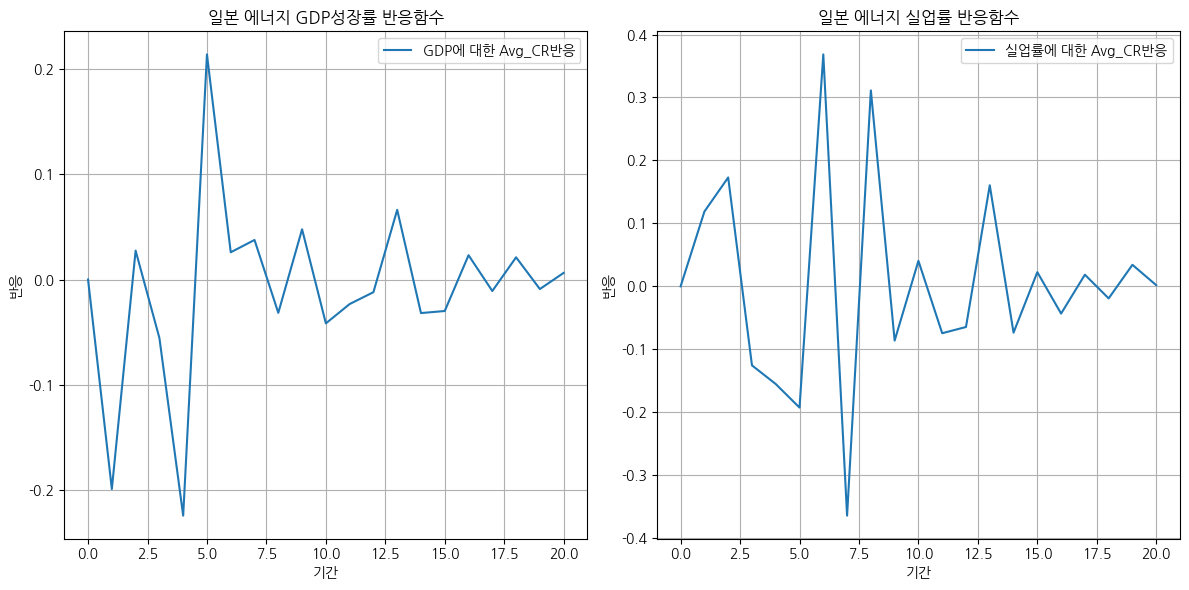

Processing file: /content/일본_소매_credit_risk_Standardized_Adjusted_transformed_log_transformed.xlsx
             log_gdp   log_실업률  log_avg_cr
기간                                        
2015-03-01  1.733814  1.539739    1.069306
2015-06-01  1.735046  1.539739    0.816733
2015-09-01  1.690114  1.492428    0.997546
2015-12-01  1.628802  1.467905    0.987178
2016-03-01  1.606110  1.416979    1.004945
2016-06-01  1.614728  1.306617    0.929525
2016-09-01  1.639990  1.277013    0.930141
2016-12-01  1.642877  1.148964    1.003979
2017-03-01  1.682235  1.148964    0.984724
2017-06-01  1.728714  1.078217    0.846423
2017-09-01  1.725936  0.919664    0.769919
2017-12-01  1.674059  0.677890    0.793054
2018-03-01  1.671310  0.358362    0.573380
2018-06-01  1.566420  0.498638    0.462573
2018-09-01  1.543684  0.562026    0.437760
2018-12-01  1.556508  0.562026    0.750053
2019-03-01  1.557650  0.358362    0.620476
2019-06-01  1.615264  0.000000    0.567696
2019-09-01  1.385150  0.102327    0.48127

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

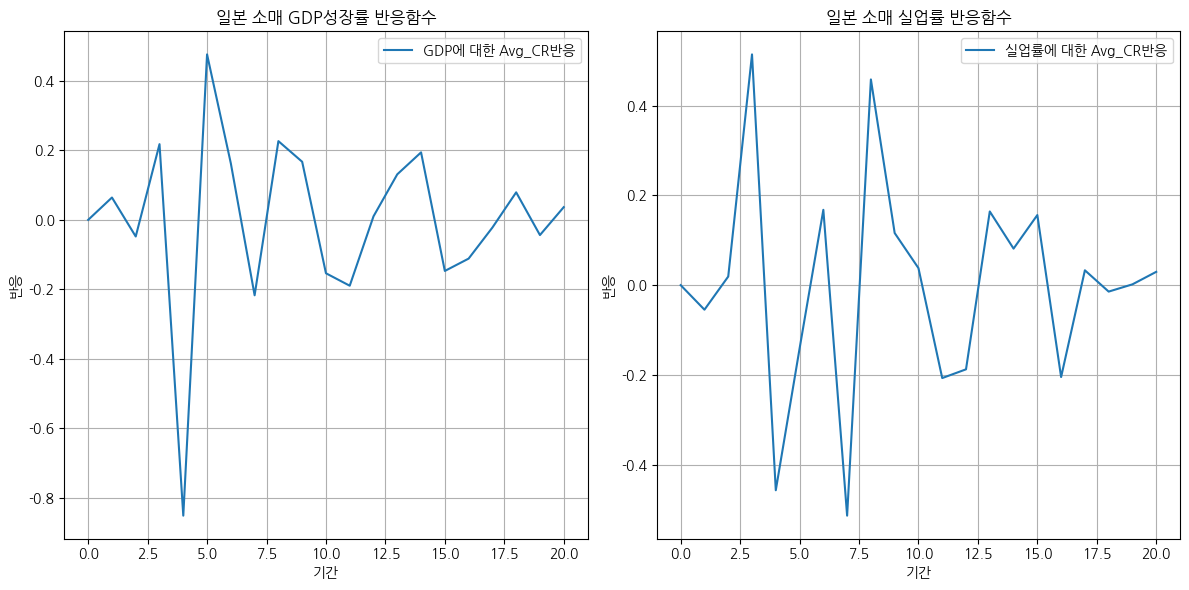

2


In [ ]:
################ VAR실시 및 그래프 나타내기
mini_file_paths = [
    '/content/인도_에너지_Credit_Risk_Extended_Standardized_Adjusted_transformed_log_transformed.xlsx',
    '/content/인도_제조_Credit_Risk_Extended_Standardized_Adjusted_transformed_log_transformed.xlsx',
    '/content/일본_에너지_credit_risk_Standardized_Adjusted_transformed_log_transformed.xlsx',
    '/content/일본_소매_credit_risk_Standardized_Adjusted_transformed_log_transformed.xlsx',
]
count = 0
# for file_paths in mini_file_paths:
for file_path in mini_file_paths:
    print(f"Processing file: {file_path}")

    # 데이터 불러오기
    data = pd.read_excel(file_path)
    data.index = data['기간']
    data = data[['log_gdp', 'log_실업률', 'log_avg_cr']]
    # 정규 표현식을 사용하여 한국어 부분 추출
    file_name = re.findall(r'[\uac00-\ud7a3]+', file_path)

    # print(data)
    # 리스트로 추출된 한국어 부분을 문자열로 결합
    korea_file_name = ' '.join(file_name)
    try:
      ###########구조적 VAR
      # 정상성 확보를 위한 처리 / 공적분 관계가 없다면
      data['diff_log_avg_cr'] = data['log_avg_cr'].diff()
      data['diff_log_실업률'] = data['log_실업률'].diff()
      data['diff_log_gdp'] = data['log_gdp'].diff()

      model_var = VAR(data[['diff_log_gdp', 'diff_log_avg_cr', 'diff_log_실업률']].dropna())
      lag_order = model_var.select_order()
      optimal_lag = lag_order.aic
      results_var = model_var.fit(maxlags=5, ic='aic')
      print(results_var.summary())
      # print("구조적 VAR 분석 결과")
      # print(results_var.summary())

      #충격반응함수 계산
      irf =  results_var.irf(20)
      # log_gdp 충격에 대한 log_avg_cr의 반응
      irf_log_avg_cr_to_log_gdp = irf.irfs[:, 1, 0]
      # log_실업률 충격에 대한 log_avg_cr의 반응
      irf_log_avg_cr_to_log_unemployment = irf.irfs[:, 1, 2]

      # 충격반응함수 그래프 생성
      plt.figure(figsize=(12, 6))

      # log_gdp 충격에 대한 log_avg_cr의 반응 그래프
      plt.subplot(1, 2, 1)
      plt.grid(True)
      plt.plot(irf_log_avg_cr_to_log_gdp, label='GDP에 대한 Avg_CR반응')
      plt.xlabel('기간')
      plt.ylabel('반응')
      plt.title(f'{korea_file_name} GDP성장률 반응함수')
      plt.legend()

      # log_실업률 충격에 대한 log_avg_cr의 반응 그래프
      plt.subplot(1, 2, 2)
      plt.grid(True)
      plt.plot(irf_log_avg_cr_to_log_unemployment, label='실업률에 대한 Avg_CR반응')
      plt.xlabel('기간')
      plt.ylabel('반응')
      plt.title(f'{korea_file_name} 실업률 반응함수')
      plt.legend()

      plt.tight_layout()
      plt.savefig(f'{korea_file_name}impulse_response_plots.png')
      files.download(f'{korea_file_name}impulse_response_plots.png')
      plt.show()
    except ValueError as e:
      print(e)
      count+=1
      print(f"{korea_file_name}가 문제")

print(count)

##**아래는 전부 테스트**

#상관계수행렬

In [ ]:
service = pd.read_excel(japan_file_paths[0])
retail = pd.read_excel(japan_file_paths[1])
energy = pd.read_excel(japan_file_paths[2])
manu = pd.read_excel(japan_file_paths[3])

In [ ]:
service = service[['gdp성장률','실업률','Credit_Risk1','Credit_Risk2','Credit_Risk3','Credit_Risk4','avg_cr']]
service.corr()

,gdp성장률,실업률,Credit_Risk1,Credit_Risk2,Credit_Risk3,Credit_Risk4,avg_cr
gdp성장률,1.000000,0.121906,-0.355147,0.048778,0.101059,0.344673,0.343334
실업률,0.121906,1.000000,0.233346,0.438761,-0.147323,0.503722,0.508438
Credit_Risk1,-0.355147,0.233346,1.000000,0.002435,-0.056803,-0.120325,-0.105009
Credit_Risk2,0.048778,0.438761,0.002435,1.000000,-0.119665,0.218712,0.218276
Credit_Risk3,0.101059,-0.147323,-0.056803,-0.119665,1.000000,-0.252824,-0.232965
Credit_Risk4,0.344673,0.503722,-0.120325,0.218712,-0.252824,1.000000,0.999641
avg_cr,0.343334,0.508438,-0.105009,0.218276,-0.232965,0.999641,1.000000


In [ ]:
retail = retail[['gdp성장률','실업률','Credit_Risk1','Credit_Risk2','Credit_Risk3','Credit_Risk4','avg_cr']]
retail.corr()

,gdp성장률,실업률,Credit_Risk1,Credit_Risk2,Credit_Risk3,Credit_Risk4,avg_cr
gdp성장률,1.000000,0.150004,-0.015420,-0.098708,0.018746,-0.045003,-0.047474
실업률,0.150004,1.000000,0.504206,0.444201,0.092589,-0.136615,0.163016
Credit_Risk1,-0.015420,0.504206,1.000000,0.820111,-0.136490,0.688624,0.837268
Credit_Risk2,-0.098708,0.444201,0.820111,1.000000,0.050887,0.567455,0.792505
Credit_Risk3,0.018746,0.092589,-0.136490,0.050887,1.000000,-0.081471,0.164235
Credit_Risk4,-0.045003,-0.136615,0.688624,0.567455,-0.081471,1.000000,0.910973
avg_cr,-0.047474,0.163016,0.837268,0.792505,0.164235,0.910973,1.000000


In [ ]:
energy = energy[['gdp성장률','실업률','Credit_Risk1','Credit_Risk2','Credit_Risk3','Credit_Risk4','avg_cr']]
energy.corr()

,gdp성장률,실업률,Credit_Risk1,Credit_Risk2,Credit_Risk3,Credit_Risk4,avg_cr
gdp성장률,1.000000,0.150004,-0.070490,0.187549,-0.155628,-0.525457,-0.243381
실업률,0.150004,1.000000,-0.167849,0.422427,-0.802947,0.034078,-0.323626
Credit_Risk1,-0.070490,-0.167849,1.000000,-0.038038,0.632213,0.360015,0.911857
Credit_Risk2,0.187549,0.422427,-0.038038,1.000000,-0.369603,-0.007970,-0.000769
Credit_Risk3,-0.155628,-0.802947,0.632213,-0.369603,1.000000,0.216735,0.749092
Credit_Risk4,-0.525457,0.034078,0.360015,-0.007970,0.216735,1.000000,0.615114
avg_cr,-0.243381,-0.323626,0.911857,-0.000769,0.749092,0.615114,1.000000


In [ ]:
manu = manu[['gdp성장률','실업률','Credit_Risk1','Credit_Risk2','Credit_Risk3','Credit_Risk4','avg_cr']]
manu.corr()

,gdp성장률,실업률,Credit_Risk1,Credit_Risk2,Credit_Risk3,Credit_Risk4,avg_cr
gdp성장률,1.000000,0.150004,-0.085981,0.152389,-0.046678,0.085955,0.030403
실업률,0.150004,1.000000,0.740342,0.362154,-0.269256,0.445964,0.704045
Credit_Risk1,-0.085981,0.740342,1.000000,0.079636,-0.498511,0.520409,0.648882
Credit_Risk2,0.152389,0.362154,0.079636,1.000000,0.586991,-0.262585,0.791702
Credit_Risk3,-0.046678,-0.269256,-0.498511,0.586991,1.000000,-0.754966,0.210544
Credit_Risk4,0.085955,0.445964,0.520409,-0.262585,-0.754966,1.000000,0.129348
avg_cr,0.030403,0.704045,0.648882,0.791702,0.210544,0.129348,1.000000


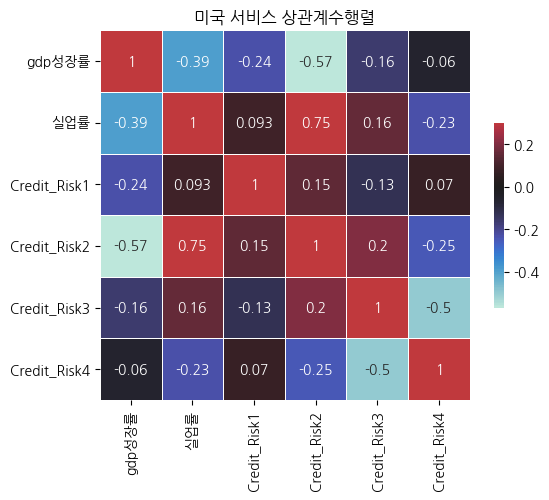

In [ ]:
sns.heatmap(us_service.corr(), vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.title('미국 서비스 상관계수행렬')
plt.show()

# 다른 국가 거시지표와 CR 상관계수행렬-이건 다른 파일에서

In [ ]:
us = pd.read_excel(us_file_paths[0])

service = pd.read_excel(india_file_paths[0])
retail = pd.read_excel(india_file_paths[1])
energy = pd.read_excel(india_file_paths[2])
manu = pd.read_excel(india_file_paths[3])

us_gdp = us['gdp성장률']
us_unemploy = us['실업률']

In [ ]:
service = service[['Credit_Risk1','Credit_Risk2','Credit_Risk3','Credit_Risk4']]
service['us_gdp'] = us_gdp
service['us_unemploy'] = us_unemploy
print(service.shape[0])
service.corr()

42


,Credit_Risk1,Credit_Risk2,Credit_Risk3,Credit_Risk4,us_gdp,us_unemploy
Credit_Risk1,1.000000,-0.027754,0.335856,0.077499,0.091546,-0.106452
Credit_Risk2,-0.027754,1.000000,0.419377,-0.038079,0.275546,-0.164461
Credit_Risk3,0.335856,0.419377,1.000000,-0.056388,0.056620,-0.156458
Credit_Risk4,0.077499,-0.038079,-0.056388,1.000000,0.061124,-0.191382
us_gdp,0.091546,0.275546,0.056620,0.061124,1.000000,-0.392732
us_unemploy,-0.106452,-0.164461,-0.156458,-0.191382,-0.392732,1.000000


#공적분 검정 및 정상성 검정

In [ ]:
# 정상성 테스트 함수
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    # for key, value in result[4].items():
    #     print(f'Critical Values {key}: {value}')
    return result[1]

#  / 비정상성을 띄는 세 시계열 데이터의 공적분 관계가 log를 취하기 전이 훨씬 더 크다.
count_stationary_cr = 0
count_stationary_gdp = 0
count_stationary_unemply = 0
count_coint_gdp = 0
count_coint_unemply = 0
for file_paths in all_file_paths:
  for file_path in file_paths:
      print("\n\n")
      # Load the provided Excel file
      data = pd.read_excel(file_path)
      print(f"Processing file: {file_path}")

      # Extract the relevant columns and drop any missing values
      filtered_data = data[['gdp성장률', '실업률', 'avg_cr']].dropna()

      # 정상성 테스트
      print("CR 데이터 정상성 테스트")
      p_value_cr = test_stationarity(data['avg_cr'])
      print("GDP 데이터 정상성 테스트")
      p_value_gdp = test_stationarity(data['gdp성장률'])
      print("실업률 데이터 정상성 테스트")
      p_value_unemployment = test_stationarity(data['실업률'])

      if (p_value_cr<0.05):
        count_stationary_cr += 1
      elif (p_value_gdp<0.05):
        count_stationary_gdp += 1
      elif (p_value_unemployment<0.05):
        count_stationary_unemply += 1

      # Split the data into features (X) and target (y)
      X = filtered_data[['gdp성장률', '실업률']]
      y = filtered_data['avg_cr']

      print("========================")
      # Coint Valuation
      _, coint_pvalue, _ = coint(X['gdp성장률'],y)
      # print('Correlation: ' + str(X.corrwith(y)))
      print('GDP Cointegration test p-value: ' + str(coint_pvalue))

      if (coint_pvalue<0.05):
        count_coint_gdp += 1

      score, coint_pvalue, _ = coint(X['실업률'],y)
      # print('Correlation: ' + str(X.corrwith(y)))
      print('실업률 Cointegration test p-value: ' + str(coint_pvalue))

      if (coint_pvalue<0.05):
        count_coint_unemply += 1
print("stationary한 avg_cr의 수 : 16/", count_stationary_cr) # 5/16
print("stationary한 gdp의 수 : 16/", count_stationary_gdp) # 8/16 사실상 2/4
print("stationary한 실업률의 수: 16/", count_stationary_unemply) # 0/16 사실상 0/4
print("gdp와 cr의 공적분 관계 : 16/", count_coint_gdp) # 8/16
print("실업률과 cr의 공적분 관계 : 16/", count_coint_unemply) # 1/16




Processing file: /content/미국_서비스_Credit_Risk_Extended(filtered).xlsx
CR 데이터 정상성 테스트
ADF Statistic: -4.378081274942095
p-value: 0.00032449772500256377
GDP 데이터 정상성 테스트
ADF Statistic: -3.155339310671502
p-value: 0.0227197795633158
실업률 데이터 정상성 테스트
ADF Statistic: -2.7380877204240157
p-value: 0.06767612349032807
GDP Cointegration test p-value: 0.03502704817807485
실업률 Cointegration test p-value: 0.16622045719221973



Processing file: /content/미국_소매_Credit_Risk_Extended(filtered).xlsx
CR 데이터 정상성 테스트
ADF Statistic: 0.2328461015856225
p-value: 0.974044817429027
GDP 데이터 정상성 테스트
ADF Statistic: -6.656358010505287
p-value: 4.972779668498735e-09
실업률 데이터 정상성 테스트
ADF Statistic: -20.335071056340723
p-value: 0.0
GDP Cointegration test p-value: 0.9859002580259643
실업률 Cointegration test p-value: 0.9859002580259643



Processing file: /content/미국_에너지_Credit_Risk_Extended(filtered).xlsx
CR 데이터 정상성 테스트
ADF Statistic: 2.7282896388182096
p-value: 0.9990879871124407
GDP 데이터 정상성 테스트
ADF Statistic: -4.35727037

In [ ]:
# 경제데이터 원본 정상성 판단

In [ ]:
# 로그차분된 경제 데이터의 정상성 판단
count_stationary_cr = 0
count_stationary_gdp = 0
count_stationary_unemploy = 0
count_coint_gdp = 0
count_coint_unemploy = 0

def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    return result[1]
for file_paths in all_file_paths:
  for file_path in file_paths:
    print(f"Processing file: {file_path}")

    # 데이터 불러오기 및 로그차분 데이터 만들기
    data = pd.read_excel(file_path)
    data.index = data['기간']
    data = data[['log_gdp', 'log_실업률']] # data = data[['log_gdp', 'log_실업률', 'log_avg_cr']]
    # data['diff_log_avg_cr'] = data['log_avg_cr'].diff().dropna()
    data['diff_log_gdp'] = data['log_gdp'].diff()
    data['diff_log_실업률'] = data['log_실업률'].diff()
    data = data.dropna()

    # 정상성 테스트
    #로그차분 GDP 데이터 정상성 테스트
    p_value_gdp = test_stationarity(data['diff_log_gdp'])
    p_value_unemployment = test_stationarity(data['diff_log_실업률'])
    if p_value_gdp <0.05:
      count_stationary_gdp += 1
    #로그차분 실업률 데이터 정상성 테스트
    elif p_value_unemployment <0.05:
      count_stationary_unemploy += 1

print(count_stationary_gdp) # 4/4
print(count_stationary_unemploy) # 2/4

Processing file: /content/미국_경제지표.xlsx
             log_gdp   log_실업률  diff_log_gdp  diff_log_실업률
기간                                                        
2014-06-01  1.613551  0.910105      0.101035     -0.029966
2014-09-01  1.637292  0.828089      0.023741     -0.082016
2014-12-01  1.621527  0.768841     -0.015764     -0.059248
2015-03-01  1.712588  0.747057      0.091060     -0.021784
2015-06-01  1.652811  0.655860     -0.059776     -0.091197
2015-09-01  1.589233  0.646325     -0.063578     -0.009535
2015-12-01  1.564309  0.593678     -0.024924     -0.052647
2016-03-01  1.538748  0.589857     -0.025561     -0.003821
2016-06-01  1.530080  0.584005     -0.008668     -0.005852
2016-09-01  1.555861  0.543986      0.025781     -0.040019
2016-12-01  1.589233  0.472565      0.033372     -0.071421
2017-03-01  1.580994  0.386307     -0.008239     -0.086258
2017-06-01  1.597405  0.383089      0.016411     -0.003218
2017-09-01  1.605511  0.299934      0.008106     -0.083155
2017-12-01  1.652

In [ ]:
# 로그차분된 avg_cr 데이터의 정상성 판단
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    return result[1]

count_stationary_cr = 0
count_stationary_gdp = 0
count_stationary_unemply = 0
count_coint_gdp = 0
count_coint_unemply = 0

for file_paths in all_file_paths_log:
  for file_path in file_paths:
    print(f"Processing file: {file_path}")
    print("\n\n")

    # 데이터 불러오기 및 로그차분 데이터 만들기
    data = pd.read_excel(file_path)
    data.index = data['기간']
    # data.columns
    data = data[['log_avg_cr']]
    # data['diff_log_avg_cr'] = data['log_avg_cr'].diff().dropna()
    data['diff_log_avg_cr'] = data['log_avg_cr'].diff()
    data = data.dropna()

    # 정상성 테스트
    print("CR 데이터 정상성 테스트")
    p_value_cr = test_stationarity(data['diff_log_avg_cr'])

    if p_value_cr < 0.05:
      count_stationary_cr += 1

print(count_stationary_cr) # 13/16

Processing file: /content/미국_서비스_Credit_Risk_Extended_Standardized_Adjusted_transformed_log_transformed.xlsx



CR 데이터 정상성 테스트
ADF Statistic: -0.5984592840184778
p-value: 0.8713297856424413
Processing file: /content/미국_소매_Credit_Risk_Extended_Standardized_Adjusted_transformed_log_transformed.xlsx



CR 데이터 정상성 테스트
ADF Statistic: -3.8306424056679895
p-value: 0.0026089110800095903
Processing file: /content/미국_에너지_Credit_Risk_Extended_Standardized_Adjusted_transformed_log_transformed.xlsx



CR 데이터 정상성 테스트
ADF Statistic: -5.4086347256172145
p-value: 3.2485903029450655e-06
Processing file: /content/미국_제조_Credit_Risk_Extended_Standardized_Adjusted_transformed_log_transformed.xlsx



CR 데이터 정상성 테스트
ADF Statistic: -2.1371972172178637
p-value: 0.22982275672801128
Processing file: /content/인도_서비스_Credit_Risk_Extended_Standardized_Adjusted_transformed_log_transformed.xlsx



CR 데이터 정상성 테스트
ADF Statistic: -9.826935053912102
p-value: 5.157893487760726e-17
Processing file: /content/인도_소매_Credit_Ris

# 신버전

In [ ]:
####################################부도율 데이터프레임 만들기
file_path = '/content/미국_제조.xlsx'
df_ = pd.read_excel(file_path)

r = 0.041
T = df_.shape[0]

def calculate_default_probability(V, D, sigma, r, T):
    d2 = (np.log(V) - np.log(D) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(-d2)

df_ = df_.replace(0, np.nan)

df = df_.dropna(subset=['영업이익1','부채1','시가총액1','영업이익2','부채2','시가총액2','영업이익3','부채3','시가총액3','영업이익4','부채4','시가총액4','gdp성장률', '실업률'])

# 시총 std
cap_volatility = df[['시가총액1', '시가총액2', '시가총액3', '시가총액4']].pct_change().std().mean()

# 부도율 계산
for i in range(1, 5):
    df[f'부도율{i}'] = calculate_default_probability(df[f'시가총액{i}'], df[f'부채{i}'], cap_volatility, r, T)

df_cleaned = df.dropna(subset=['gdp성장률', '실업률', '부도율1', '부도율2', '부도율3', '부도율4'])

In [ ]:
####################################데이터 정규화
scaler = StandardScaler()
df_cleaned[['gdp성장률', '실업률']] = scaler.fit_transform(df_cleaned[['gdp성장률', '실업률']])
for i in range(1, 5):
    df_cleaned[f'부도율{i}'] = scaler.fit_transform(df_cleaned[[f'부도율{i}']])

df_var = df_cleaned[['gdp성장률', '실업률', '부도율1', '부도율2', '부도율3', '부도율4']]

In [ ]:
####################################데이터 정규화 및 시각화
# 정규화함수
def standardize_and_adjust_data(df):
    scaler = StandardScaler()
    data_to_standardize = df.drop(columns=['기간'])
    standardized_data = pd.DataFrame(scaler.fit_transform(data_to_standardize), columns=data_to_standardize.columns)
    standardized_data = standardized_data - standardized_data.iloc[0]
    standardized_data['기간'] = df['기간']
    return standardized_data

# 파일경로
file_paths = [
    "ex) 미국_서비스_cleaned_default_probabilities파일의 path",
    "",
    "",
    "",
]

# 정규화 파일 생성 후 딕셔너리 변수에 저장
adjusted_standardized_data_files = {}
for file_path in file_paths:
    data = pd.read_excel(file_path, sheet_name='Sheet1')
    adjusted_standardized_data = standardize_and_adjust_data(data)
    adjusted_standardized_file_path = file_path.replace('.xlsx', '_adjusted_standardized.xlsx')
    adjusted_standardized_data.to_excel(adjusted_standardized_file_path, index=False)
    adjusted_standardized_data_files[file_path] = adjusted_standardized_file_path

# ploting
for file_path, adjusted_standardized_file_path in adjusted_standardized_data_files.items():
    adjusted_standardized_data = pd.read_excel(adjusted_standardized_file_path)

    plt.figure(figsize=(14, 8))
    for column in adjusted_standardized_data.columns:
        if column != '기간':
            plt.plot(adjusted_standardized_data['기간'], adjusted_standardized_data[column], label=column)

    plt.title(f'{file_path.split("/")[-1].replace("_cleaned_default_probabilities.xlsx", "")} - Adjusted Standardized Data')
    plt.xlabel('기간')
    plt.ylabel('Adjusted Standardized Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# 그래프 찍어보기
adjusted_standardized_data_files

           기간       영업이익1        부채1        시가총액1       영업이익2          부채2  \
4  2014-03-01  -27.295800   869.5274  2652.977704 -198.690881   717.179627   
5  2014-06-01   85.825600   862.6016  2383.740716 -362.848094  1074.415243   
6  2014-09-01 -669.901400  1727.1044  2649.209757 -158.820001  1183.661590   
7  2014-12-01 -643.556200   693.8022  2223.089129 -948.203673  1040.628067   
8  2015-03-01  570.088400   675.6050  2360.105408 -165.072776  1182.394711   
9  2015-06-01  127.787800   751.9246  2277.895640 -203.823171  1208.818947   
10 2015-09-01  153.182400   768.6280  2469.718431 -156.423674  1644.278079   
11 2015-12-01  913.662400   681.5802  2860.214827 -946.058441  2101.584443   
12 2016-03-01   50.110200   619.2480  2538.226571 -136.128908  1770.513685   
13 2016-06-01  194.737200   630.1120  3377.108740  -99.367848  1297.082293   
14 2016-09-01   75.640600   630.1120  3848.102199  -82.121927  2276.113381   
15 2016-12-01   -0.543200   834.0836  3449.384827 -487.483161  1

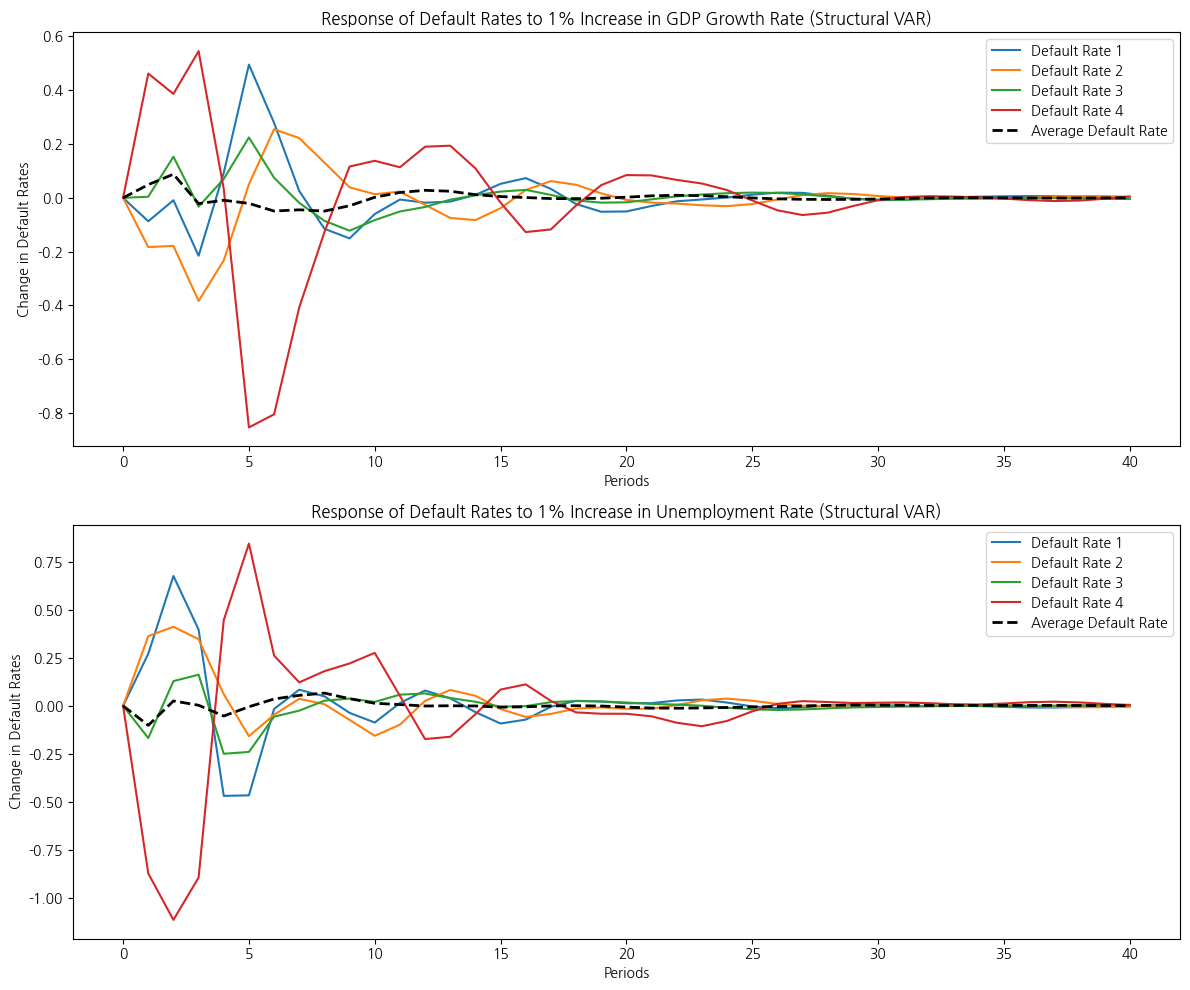

In [ ]:
#VAR
model = VAR(df_var)
results = model.fit(maxlags=3, ic='aic')

# 충격반응함수 기간 설정
irf = results.irf(df_var.shape[0])

# IRF값 받기
irf_gdp_to_default1 = irf.orth_irfs[:, 0, 2]
irf_gdp_to_default2 = irf.orth_irfs[:, 0, 3]
irf_gdp_to_default3 = irf.orth_irfs[:, 0, 4]
irf_gdp_to_default4 = irf.orth_irfs[:, 0, 5]

irf_unemployment_to_default1 = irf.orth_irfs[:, 1, 2]
irf_unemployment_to_default2 = irf.orth_irfs[:, 1, 3]
irf_unemployment_to_default3 = irf.orth_irfs[:, 1, 4]
irf_unemployment_to_default4 = irf.orth_irfs[:, 1, 5]
####################################구조적 VAR 및 충격반응함수 결과

# GDP에 대한 개별 중소기업들의 충격반으함수의 평균값
irf_gdp_to_default_avg = (irf_gdp_to_default1 + irf_gdp_to_default2 + irf_gdp_to_default3 + irf_gdp_to_default4) / 4
# 실업률에 대한 개별 중소기업들의 충격반응함수의 평균값
irf_unemployment_to_default_avg = (irf_unemployment_to_default1 + irf_unemployment_to_default2 + irf_unemployment_to_default3 + irf_unemployment_to_default4) / 4

periods = range(41)

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# gdp->CR 영향을 분석한 VAR결과 plot
axes[0].plot(periods, irf_gdp_to_default1, label='Default Rate 1')
axes[0].plot(periods, irf_gdp_to_default2, label='Default Rate 2')
axes[0].plot(periods, irf_gdp_to_default3, label='Default Rate 3')
axes[0].plot(periods, irf_gdp_to_default4, label='Default Rate 4')
axes[0].plot(periods, irf_gdp_to_default_avg, label='Average Default Rate', linestyle='--', linewidth=2, color='black')
axes[0].set_title('Response of Default Rates to 1% Increase in GDP Growth Rate (Structural VAR)')
axes[0].set_xlabel('Periods')
axes[0].set_ylabel('Change in Default Rates')
axes[0].legend()

# 실업률->CR 영향을 분석한 VAR결과 plot
axes[1].plot(periods, irf_unemployment_to_default1, label='Default Rate 1')
axes[1].plot(periods, irf_unemployment_to_default2, label='Default Rate 2')
axes[1].plot(periods, irf_unemployment_to_default3, label='Default Rate 3')
axes[1].plot(periods, irf_unemployment_to_default4, label='Default Rate 4')
axes[1].plot(periods, irf_unemployment_to_default_avg, label='Average Default Rate', linestyle='--', linewidth=2, color='black')
axes[1].set_title('Response of Default Rates to 1% Increase in Unemployment Rate (Structural VAR)')
axes[1].set_xlabel('Periods')
axes[1].set_ylabel('Change in Default Rates')
axes[1].legend()

plt.tight_layout()
plt.show()


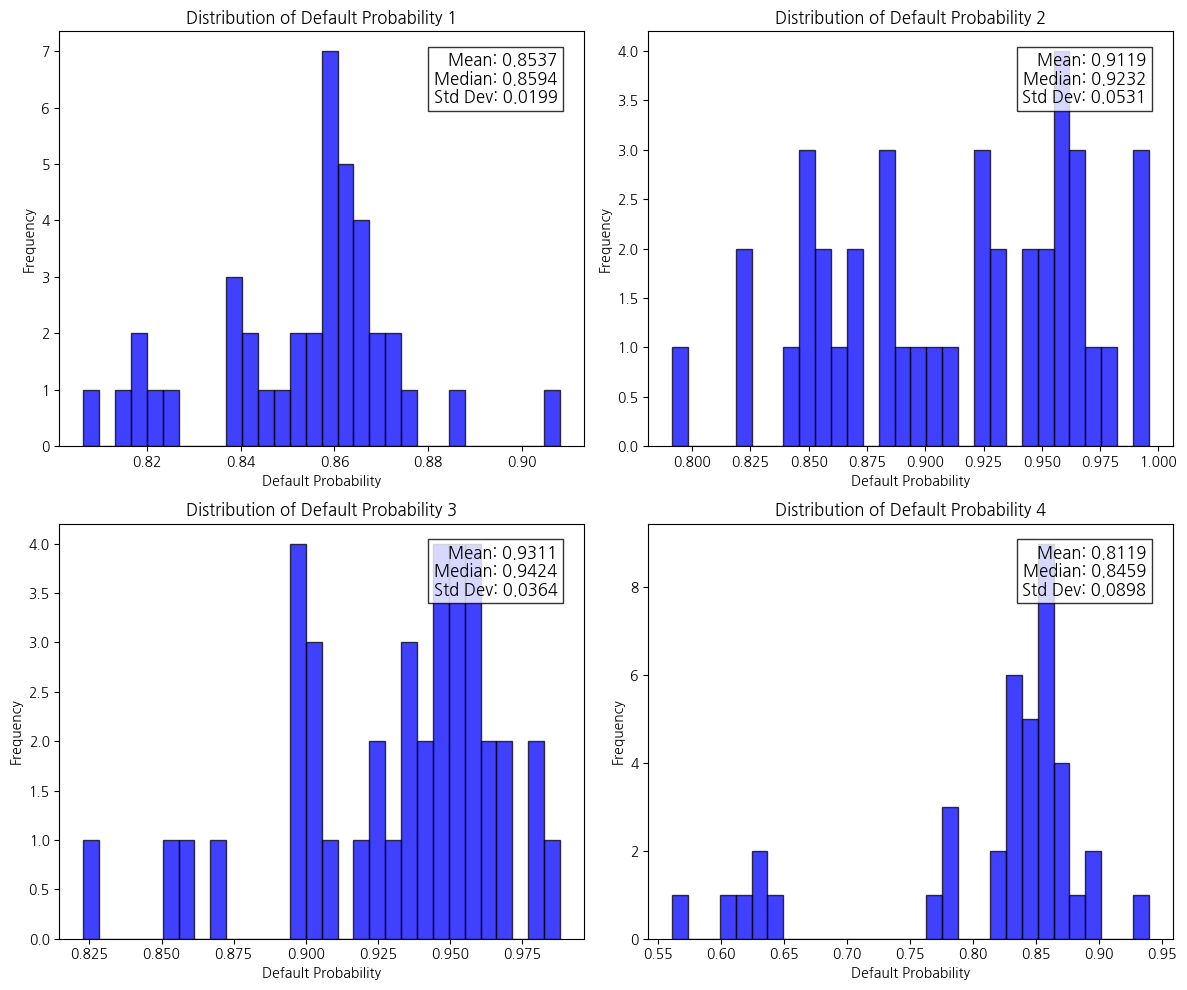

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, ax in enumerate(axes.flatten(), 1):
    data = df[f'부도율{i}'].dropna()
    ax.hist(data, bins=30, alpha=0.75, color='blue', edgecolor='black')
    ax.set_title(f'Distribution of Default Probability {i}')
    ax.set_xlabel('Default Probability')
    ax.set_ylabel('Frequency')

    # 기초통계량
    mean = np.mean(data)
    median = np.median(data)
    std_dev = np.std(data)

    textstr = '\n'.join((
        f'Mean: {mean:.4f}',
        f'Median: {median:.4f}',
        f'Std Dev: {std_dev:.4f}'
    ))
    ax.text(0.95, 0.95, textstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

In [ ]:
irf_unemployment_df = pd.DataFrame(
    data = {
    '부도율1':irf_unemployment_to_default1,
    '부도율2':irf_unemployment_to_default2,
    '부도율3':irf_unemployment_to_default3,
    '부도율4':irf_unemployment_to_default4,
    '평균부도율-실업률':irf_unemployment_to_default_avg
    }
)
irf_unemployment_df

,부도율1,부도율2,부도율3,부도율4,평균부도율-gdp,평균부도율-실업률
0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
1,6.833540e-02,0.093686,-4.167317e-01,-6.877268e-02,6.573361e-02,-0.080871
2,1.385784e-01,0.069797,-3.044378e-01,7.440230e-03,7.404516e-02,-0.022155
3,1.325255e-01,0.042982,-1.377724e-01,5.856157e-02,9.874049e-03,0.024074
4,8.877018e-02,0.037441,-4.826354e-02,6.284079e-02,-3.289123e-02,0.035197
5,5.155777e-02,0.040942,-2.435938e-02,4.580604e-02,-3.569353e-02,0.028487
6,3.312181e-02,0.041341,-2.219870e-02,2.954375e-02,-2.144328e-02,0.020452
7,2.603918e-02,0.036453,-1.802137e-02,2.021224e-02,-9.795263e-03,0.016171
8,2.164632e-02,0.029346,-9.747058e-03,1.524663e-02,-5.264253e-03,0.014123
9,1.676014e-02,0.022817,-2.203431e-03,1.150462e-02,-4.475190e-03,0.012220


In [ ]:
irf_gdp_df = pd.DataFrame(
    data = {
    '부도율1':irf_gdp_to_default1,
    '부도율2':irf_gdp_to_default2,
    '부도율3':irf_gdp_to_default3,
    '부도율4':irf_gdp_to_default4,
    '평균부도율-gdp':irf_gdp_to_default_avg,
    }
)
irf_gdp_df

,부도율1,부도율2,부도율3,부도율4,평균부도율-gdp
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,2.005660e-01,-1.793685e-01,1.146725e-01,1.270645e-01,6.573361e-02
2,4.462875e-02,-1.795038e-01,3.027186e-01,1.283370e-01,7.404516e-02
3,-8.248464e-02,-9.844815e-02,1.844423e-01,3.598666e-02,9.874049e-03
4,-9.323030e-02,-4.043975e-02,2.560014e-02,-2.349501e-02,-3.289123e-02
5,-5.040077e-02,-2.324331e-02,-4.022109e-02,-2.890893e-02,-3.569353e-02
6,-1.526589e-02,-2.403351e-02,-3.423935e-02,-1.223436e-02,-2.144328e-02
7,-3.070524e-03,-2.403953e-02,-1.265137e-02,5.803690e-04,-9.795263e-03
8,-3.290404e-03,-1.925837e-02,-2.579925e-03,4.071684e-03,-5.264253e-03
9,-4.760256e-03,-1.294927e-02,-3.167896e-03,2.976663e-03,-4.475190e-03


In [ ]:
# gdp가 1퍼센트 상승했을 때 부도율의 변화(%)
gdp_to_default_std_lst = []
for i in range(1,5):
    data = df[f'부도율{i}'].dropna()
    # mean = np.mean(data)
    # median = np.median(data)
    std_dev = np.std(data)

    gdp_to_default_std_lst.append(std_dev)

irf_gdp_to_default_avg_std = np.std(irf_gdp_to_default_avg)
irf_gdp_percent_df = pd.DataFrame(
    data = {
    '부도율1':irf_gdp_to_default1*gdp_to_default_std_lst[0],
    '부도율2':irf_gdp_to_default2*gdp_to_default_std_lst[1],
    '부도율3':irf_gdp_to_default3*gdp_to_default_std_lst[2],
    '부도율4':irf_gdp_to_default4*gdp_to_default_std_lst[3],
    '평균부도율-gdp':irf_gdp_to_default_avg*irf_gdp_to_default_avg_std,
    }
)
irf_gdp_percent_df

,부도율1,부도율2,부도율3,부도율4,평균부도율-gdp
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,3.998857e-03,-9.517958e-03,4.177372e-03,1.140779e-02,1.164510e-03
2,8.898019e-04,-9.525136e-03,1.102765e-02,1.152204e-02,1.311754e-03
3,-1.644568e-03,-5.224024e-03,6.718998e-03,3.230866e-03,1.749246e-04
4,-1.858813e-03,-2.145883e-03,9.325802e-04,-2.109371e-03,-5.826876e-04
5,-1.004884e-03,-1.233376e-03,-1.465203e-03,-2.595431e-03,-6.323319e-04
6,-3.043692e-04,-1.275307e-03,-1.247296e-03,-1.098395e-03,-3.798803e-04
7,-6.121968e-05,-1.275627e-03,-4.608731e-04,5.210526e-05,-1.735289e-04
8,-6.560363e-05,-1.021920e-03,-9.398335e-05,3.655539e-04,-9.325935e-05
9,-9.490933e-05,-6.871363e-04,-1.154024e-04,2.672435e-04,-7.928063e-05


<Axes: >

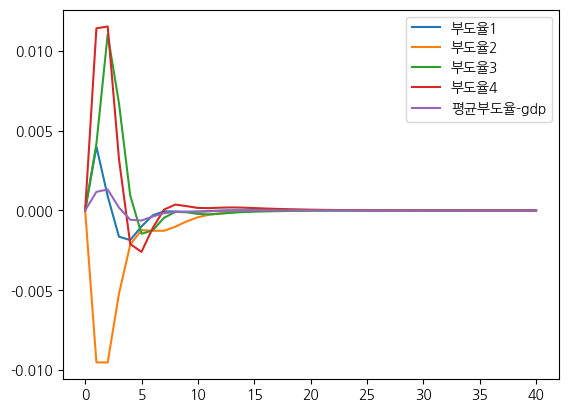

In [ ]:
irf_gdp_percent_df.plot()